# Data processing for bump hunt

Main differences for bump hunt:
- No fully supervised set
- test set covers the whole SR / SB range



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from helpers.plotting import *
from helpers.physics_functions import *
from helpers.data_transforms import *

plt.style.use("../science.mplstyle")


In [2]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)

In [3]:
project_id = "lowmass"
scaler_id = "logit_08_22"
path_to_compiled_data = f"/pscratch/sd/r/rmastand/dimuonAD/compiled_data/{project_id}"

    
if project_id == "lowmass":
    codes_list = ["DATA_nojet"]
    sim_id = "DATA_nojet"
    signal_id = "DATA_nojet"

    
uncut_data, uncut_data_samesign = {code:{} for code in codes_list},  {code:{} for code in codes_list}

for code in codes_list:
    with open(f"{path_to_compiled_data}/{code}", "rb") as ifile:
        tmp_dict = pickle.load(ifile)
        for key in tmp_dict.keys():
            if "samesign" in key:
                uncut_data_samesign[code][key[:-9]] = tmp_dict[key]
            else:
                uncut_data[code][key] = tmp_dict[key]
        
    
    print(code, "opp sign",  uncut_data[code][list(uncut_data[code].keys())[0]].shape)
    print(code, "same sign", uncut_data_samesign[code][list(uncut_data[code].keys())[0]].shape)

DATA_nojet opp sign (21803678,)
DATA_nojet same sign (6756613,)


## Visualize the data

In [4]:
feature_set = list(uncut_data[codes_list[0]].keys())
print(feature_set)

#hist_all_features(codes_list, uncut_data, feature_set, kwargs_dict_dtype, nice_labels=True)
    


['mu0_iso03', 'mu1_iso03', 'mu0_eta', 'mu1_eta', 'mu0_pt', 'mu1_pt', 'mu0_phi', 'mu1_phi', 'mu0_iso04', 'mu1_iso04', 'dimu_pt', 'dimu_eta', 'dimu_phi', 'n_muons', 'n_jets', 'dimu_mass', 'mumu_deltaR', 'mumu_deltapT']


## Make cuts

Now let's define cuts on the data. 

Muon cuts were made previously (and we don't want to make cuts on the dimuon system, either)

Random seed is used to set aside a portion of the test set

In [5]:
particle_type = "eta"



SB_left = float(workflow[particle_type]["SB_left"])
SR_left = float(workflow[particle_type]["SR_left"])
SR_right = float(workflow[particle_type]["SR_right"])
SB_right = float(workflow[particle_type]["SB_right"])



band_bounds = {"SBL": [SB_left,SR_left],
                   "SR": [SR_left,SR_right],
                   "SBH": [SR_right,SB_right],
                           }

if particle_type == "eta":
    N_test = 32000
    random_seed = 2


elif particle_type == "upsilon":
    N_test = 32000
    random_seed = 6
    
    
else:
    N_test = 32000
    random_seed = 7

plot_bins_SR = np.linspace(SR_left, SR_right, 6)
width = plot_bins_SR[1] - plot_bins_SR[0]


In [6]:
cut_data, cut_data_samesign = {code:{} for code in codes_list},  {code:{} for code in codes_list}

for code in codes_list:
    
    # define cuts to reduce the starting significance
    if "upsilon" in particle_type:
        pass_indices = (uncut_data[code]["mu0_iso04"] > 0.65) & (uncut_data[code]["mu1_iso04"] > 0.65)
        pass_indices_samesign = (uncut_data_samesign[code]["mu0_iso04"] > 0.65) & (uncut_data_samesign[code]["mu1_iso04"] > 0.65)
        
    else:
        # these cuts do nothing
        pass_indices = (uncut_data[code]["mu0_iso04"] > -.5) & (uncut_data[code]["mu1_iso04"] > -.5)
        pass_indices_samesign = (uncut_data_samesign[code]["mu0_iso04"] > -.5) & (uncut_data_samesign[code]["mu1_iso04"] > -.5)
    
    
    # apply cuts to oppsign
    for feat in feature_set:
        cut_data[code][feat] = uncut_data[code][feat][pass_indices]
    # apply cuts to samesign
    for feat in feature_set:
        cut_data_samesign[code][feat] = uncut_data_samesign[code][feat][pass_indices_samesign]
    
    print(f"{code} oppsign has shape {cut_data[code][feat].shape} after cuts")
    print(f"{code} samesign has shape {cut_data_samesign[code][feat].shape} after cuts")
    

DATA_nojet oppsign has shape (21803678,) after cuts
DATA_nojet samesign has shape (6756613,) after cuts


Check how local cuts affect the starting significance

(554309,)


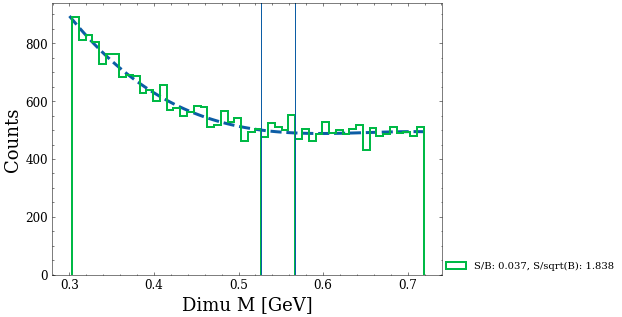

In [7]:
p0  = [5000, -20000, 30000, -10000]

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, True)

x = np.linspace(SB_left, SB_right, 100) # plot curve fit

masses_with_bounds = cut_data[code]["dimu_mass"][(cut_data[code]["dimu_mass"] >= SB_left) & (cut_data[code]["dimu_mass"] <= SB_right)]
masses_with_bounds_samesign = cut_data_samesign[code]["dimu_mass"][(cut_data_samesign[code]["dimu_mass"] >= SB_left) & (cut_data_samesign[code]["dimu_mass"] <= SB_right)]


plt.figure(figsize = (7,5))

# plot all data
loc_data = masses_with_bounds
print(loc_data.shape)
popt_0, _, _, _, _ = curve_fit_m_inv(loc_data, "cubic", SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all)
#plt.plot(x, bkg_fit_cubic(x, *popt_0), lw = 3, linestyle = "dashed")
num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(loc_data, bkg_fit_cubic, plot_bins_SR, SR_left, SR_right, popt_0)

#plt.hist(loc_data, bins = bins, lw = 2, histtype = "step", density = False, label = f"S/B: {round(num_S_expected_in_SR/num_B_expected_in_SR,3)}, S/sqrt(B): {round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR),3)}")


# plot subset of data
np.random.shuffle(masses_with_bounds)
loc_data = masses_with_bounds[:30000]
popt_0, _, _, _, _ = curve_fit_m_inv(loc_data, "cubic", SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all)
plt.plot(x, bkg_fit_cubic(x, *popt_0), lw = 3, linestyle = "dashed")
num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(loc_data, bkg_fit_cubic, plot_bins_SR, SR_left, SR_right, popt_0)
plt.hist(loc_data, bins = plot_bins_all, lw = 2, histtype = "step", density = False, label = f"S/B: {round(num_S_expected_in_SR/num_B_expected_in_SR,3)}, S/sqrt(B): {round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR),3)}")


plt.axvline(SR_left)
plt.axvline(SR_right)

plt.xlabel("Dimu M [GeV]")
plt.ylabel("Counts")
plt.legend(loc = (1, 0))


plt.show()
 
    
#hist_all_features(codes_list, cut_data, feature_set, kwargs_dict_dtype)


/global/homes/r/rmastand/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


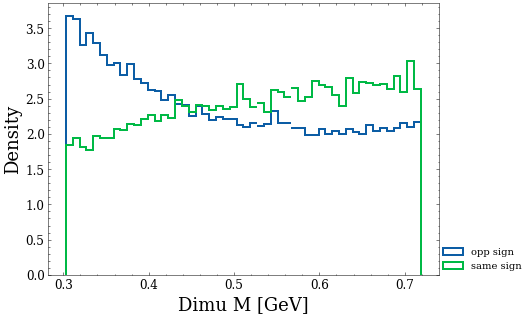

In [8]:

plt.figure(figsize = (7,5))

# plot all data
loc_data = masses_with_bounds
plt.hist(loc_data, bins = plot_bins_all, lw = 2, histtype = "step", density = True, label = f"opp sign")
plt.hist(masses_with_bounds_samesign, bins = plot_bins_all, lw = 2, histtype = "step", density = True, label = f"same sign")


plt.xlabel("Dimu M [GeV]")
plt.ylabel("Density")
plt.legend(loc = (1, 0))


plt.show()
 
    
#hist_all_features(codes_list, cut_data, feature_set, kwargs_dict_dtype)


Split data into bands

In [9]:
bands = ["SBL", "SR", "SBH"]
N_total_events = 0



preproc_dicts, preproc_dicts_samesign = {b:{} for b in bands}, {b:{} for b in bands}


for code in codes_list:
    for b in bands:

        # opp sign
        loc_pass_indices = (cut_data[code]["dimu_mass"] >= band_bounds[b][0]) & (cut_data[code]["dimu_mass"] < band_bounds[b][1])
        preproc_dicts[b][code] = {}
        for feat in feature_set:
            preproc_dicts[b][code][feat] = cut_data[code][feat][loc_pass_indices]
            
       
        N_total_events += preproc_dicts[b][code][feat].shape[0]
        
        # same sign
        loc_pass_indices_samesign = (cut_data_samesign[code]["dimu_mass"] >= band_bounds[b][0]) & (cut_data_samesign[code]["dimu_mass"] < band_bounds[b][1])
        preproc_dicts_samesign[b][code] = {}
        for feat in feature_set:
            preproc_dicts_samesign[b][code][feat] = cut_data_samesign[code][feat][loc_pass_indices_samesign]
  
    
    
print(f"Total events: {N_total_events}")
    

Total events: 554309


## Preprocessing

Standard scaling is fine

In [13]:
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, MinMaxScaler

sizes_dict = {}



proccessed_data_dict, proccessed_data_dict_samesign  = {b:{"s_inj_data":{}} for b in bands}, {b:{"s_inj_data":{}} for b in bands}

for feat in feature_set: 
    
    # train the preprocessor on the opp sign data only
    
    data_SB = np.hstack((preproc_dicts["SBL"][sim_id][feat], preproc_dicts["SBH"][sim_id][feat])).reshape(-1, 1)
    data_all = np.hstack((preproc_dicts["SBL"][sim_id][feat], preproc_dicts["SBH"][sim_id][feat], preproc_dicts["SR"][sim_id][feat])).reshape(-1, 1)
    all_min = np.min(data_all)
    all_max = np.max(data_all)
    
    if feat == "dimu_mass":
        processed_mass_info = {"min":0, "max":0, "mean":0, "std":0}
        processed_mass_info["min"] = all_min
        processed_mass_info["max"] = all_max

    # logit transform the features
    
    transformed_feats = logit_transform(data_SB, all_min, all_max)
    print(data_SB.shape, transformed_feats.shape)
    # subtract off mean, std of the training set
    mean_to_sub = np.mean(transformed_feats)
    std_to_sub = np.std(transformed_feats)
    
    if feat == "dimu_mass":
        processed_mass_info["mean"] = mean_to_sub
        processed_mass_info["std"] = std_to_sub
        with open(f"projects/{scaler_id}/processed_data/mass_scaler_{particle_type}", "wb") as ofile:
            pickle.dump(processed_mass_info, ofile)

    
    for b in bands:
        proccessed_data_dict[b]["s_inj_data"][feat] = (logit_transform(preproc_dicts[b][sim_id][feat], all_min, all_max) - mean_to_sub)/std_to_sub
        proccessed_data_dict_samesign[b]["s_inj_data"][feat] = (logit_transform(preproc_dicts_samesign[b][sim_id][feat], all_min, all_max) - mean_to_sub)/std_to_sub
         
        print(np.max(proccessed_data_dict[b]["s_inj_data"][feat]), np.min(proccessed_data_dict[b]["s_inj_data"][feat]))
            
        sizes_dict[b] = proccessed_data_dict[b]["s_inj_data"][feat].shape[0]
        
    
"""
for feat in feature_set: 
    
    # train the preprocessor on the opp sign data only
    SB_all = np.hstack((preproc_dicts["SBL"][sim_id][feat], preproc_dicts["SBH"][sim_id][feat])).reshape(-1, 1)
    loc_feat_scaler = PowerTransformer()
    loc_feat_scaler = loc_feat_scaler.fit(SB_all)
    
    a = loc_feat_scaler.transform(SB_all)
    
    
  
    if feat == "dimu_mass":
        with open(f"projects/{scaler_id}/processed_data/mass_scaler_{particle_type}", "wb") as ofile:
            pickle.dump(loc_feat_scaler, ofile)
            mass_scaler = loc_feat_scaler
    
    
    for b in bands:
        
        
        
        proccessed_data_dict[b]["s_inj_data"][feat] = loc_feat_scaler.transform(preproc_dicts[b][sim_id][feat].reshape(-1, 1))
        
        proccessed_data_dict_samesign[b]["s_inj_data"][feat] = loc_feat_scaler.transform(preproc_dicts_samesign[b][sim_id][feat].reshape(-1, 1))
        
       
        # robust scaler
        # extra preprocessing to get centers closer to zero
        if ("pt" in feat) or ("pT" in feat):
            proccessed_data_dict[b]["s_inj_data"][feat] = proccessed_data_dict[b]["s_inj_data"][feat]/2
            proccessed_data_dict_samesign[b]["s_inj_data"][feat] = proccessed_data_dict_samesign[b]["s_inj_data"][feat]/2
     
        
       
        #standard scaler
        # extra preprocessing to get centers closer to zero
        if ("pt" in feat) or ("iso" in feat) or ("deltapT" in feat):
            proccessed_data_dict[b]["s_inj_data"][feat] = (proccessed_data_dict[b]["s_inj_data"][feat])/4 - 2
            proccessed_data_dict_samesign[b]["s_inj_data"][feat] = (proccessed_data_dict_samesign[b]["s_inj_data"][feat])/4 - 2
        if ("dimu_eta" in feat):
            proccessed_data_dict[b]["s_inj_data"][feat] = (proccessed_data_dict[b]["s_inj_data"][feat])/2
            proccessed_data_dict_samesign[b]["s_inj_data"][feat] = (proccessed_data_dict_samesign[b]["s_inj_data"][feat])/2
        if "eta" in particle_type:
            if ("deltaR" in feat):
                proccessed_data_dict[b]["s_inj_data"][feat] = (proccessed_data_dict[b]["s_inj_data"][feat])/2.5-1.5
                proccessed_data_dict_samesign[b]["s_inj_data"][feat] = (proccessed_data_dict_samesign[b]["s_inj_data"][feat])/2.5-1.5

       
 """


(506682, 1) (506682, 1)
14.511291 -0.7337032
8.438641 -0.7337032
9.997686 -0.7337032
(506682, 1) (506682, 1)
11.325455 -0.7122302
9.203357 -0.7122302
14.029096 -0.7122302
(506682, 1) (506682, 1)
3.716505 -3.6829774
3.50489 -3.6829774
3.7005854 -3.7298443
(506682, 1) (506682, 1)
3.6594446 -3.7332463
3.6519547 -3.5796602
3.7138662 -3.620716
(506682, 1) (506682, 1)
16.720663 -3.7782717
9.00038 -3.7645195
9.353534 -3.7645025
(506682, 1) (506682, 1)
8.05355 -3.1059391
12.2846 -3.1037047
7.656665 -3.1054592
(506682, 1) (506682, 1)
2.779323 -2.775861
2.779323 -2.771228
2.779323 -2.775861
(506682, 1) (506682, 1)
2.778636 -2.7763336
2.7740026 -2.7763336
2.778636 -2.7763336
(506682, 1) (506682, 1)
15.514024 -0.7687104
8.356469 -0.7687104
9.114984 -0.7687104
(506682, 1) (506682, 1)
10.908781 -0.7622686
9.002706 -0.7622686
13.736228 -0.7622686
(506682, 1) (506682, 1)
15.906962 -4.2522926
9.108845 -4.2277446
11.03837 -4.22835
(506682, 1) (506682, 1)
3.7044578 -3.7189007
3.5747209 -3.7006407
3.65736

'\nfor feat in feature_set: \n    \n    # train the preprocessor on the opp sign data only\n    SB_all = np.hstack((preproc_dicts["SBL"][sim_id][feat], preproc_dicts["SBH"][sim_id][feat])).reshape(-1, 1)\n    loc_feat_scaler = PowerTransformer()\n    loc_feat_scaler = loc_feat_scaler.fit(SB_all)\n    \n    a = loc_feat_scaler.transform(SB_all)\n    \n    \n  \n    if feat == "dimu_mass":\n        with open(f"projects/{scaler_id}/processed_data/mass_scaler_{particle_type}", "wb") as ofile:\n            pickle.dump(loc_feat_scaler, ofile)\n            mass_scaler = loc_feat_scaler\n    \n    \n    for b in bands:\n        \n        \n        \n        proccessed_data_dict[b]["s_inj_data"][feat] = loc_feat_scaler.transform(preproc_dicts[b][sim_id][feat].reshape(-1, 1))\n        \n        proccessed_data_dict_samesign[b]["s_inj_data"][feat] = loc_feat_scaler.transform(preproc_dicts_samesign[b][sim_id][feat].reshape(-1, 1))\n        \n       \n        # robust scaler\n        # extra prepro

In [11]:
print(sizes_dict)

{'SBL': 334327, 'SR': 47627, 'SBH': 172355}


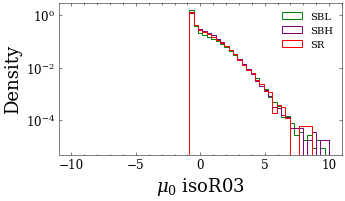

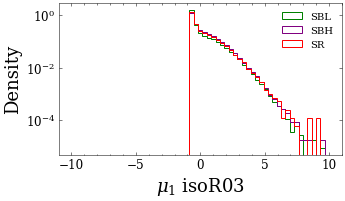

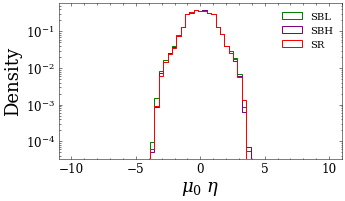

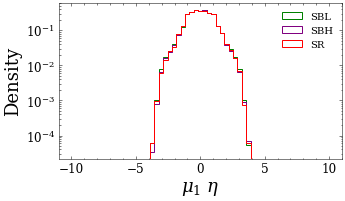

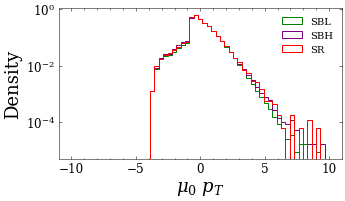

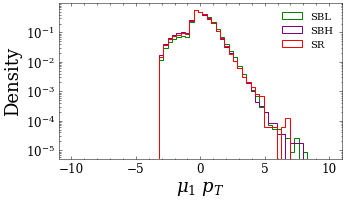

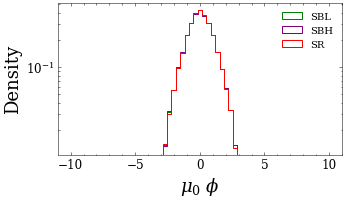

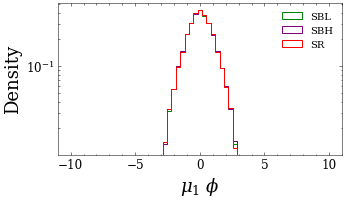

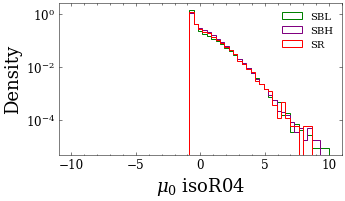

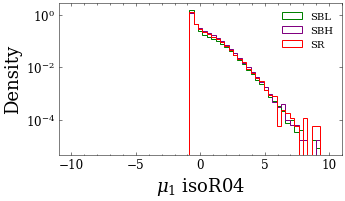

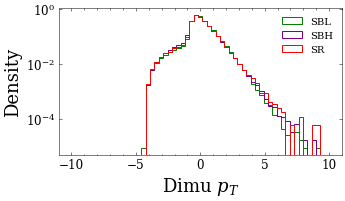

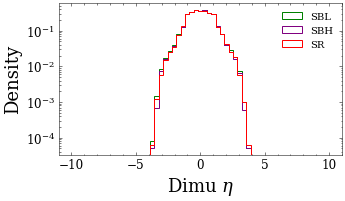

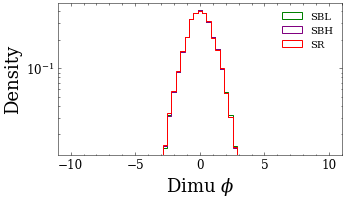

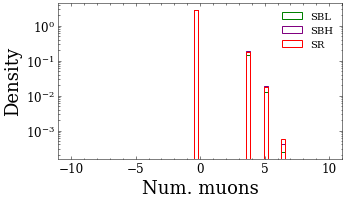

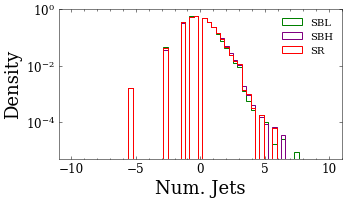

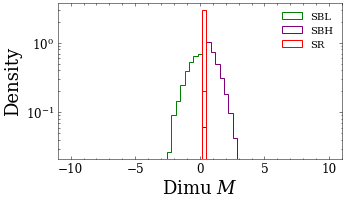

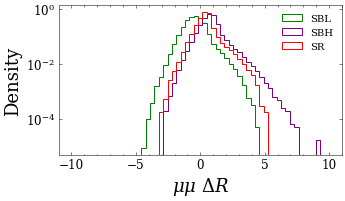

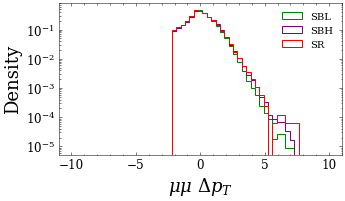

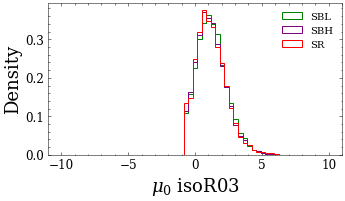

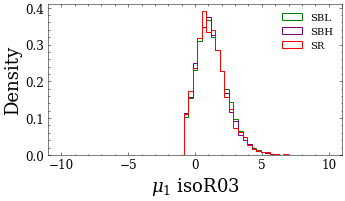

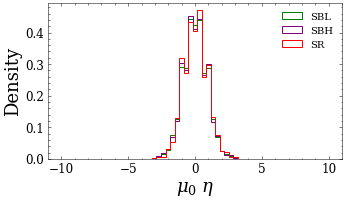

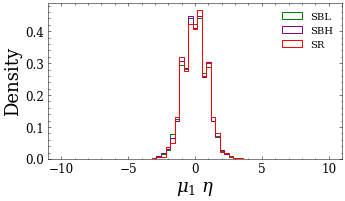

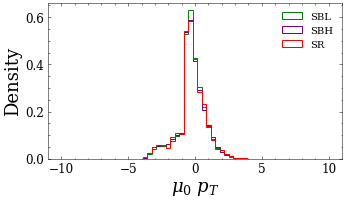

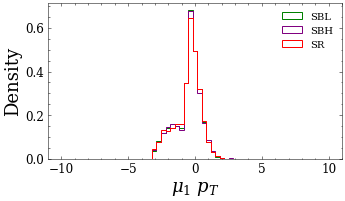

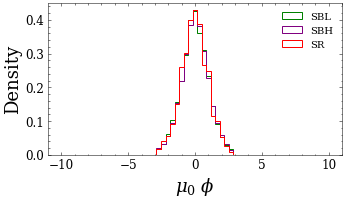

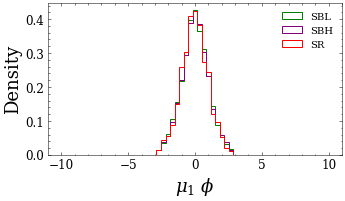

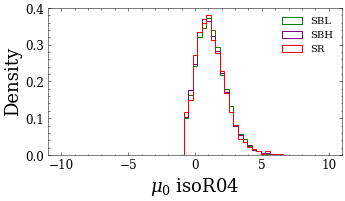

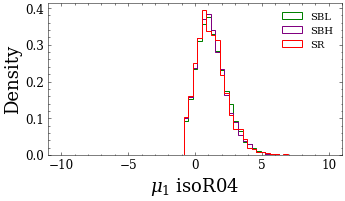

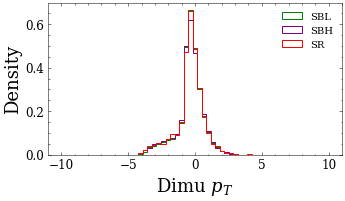

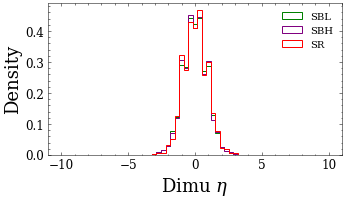

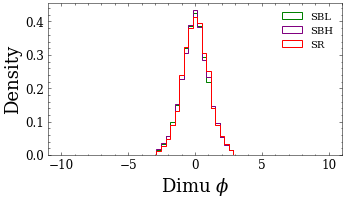

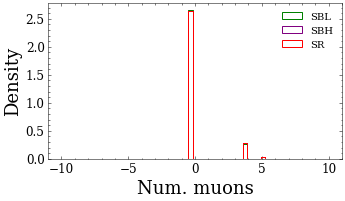

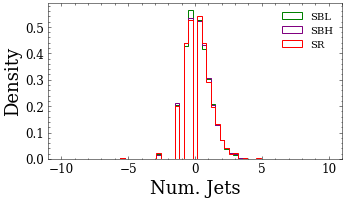

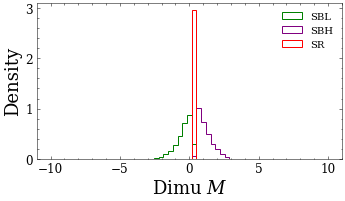

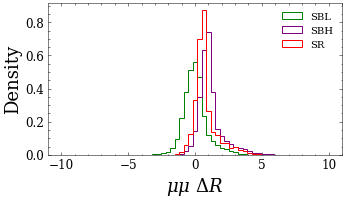

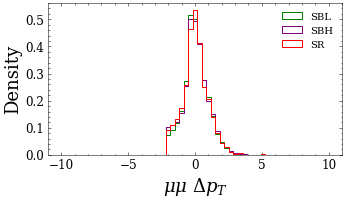

In [12]:
hist_all_features_dict([proccessed_data_dict["SBL"]["s_inj_data"], proccessed_data_dict["SBH"]["s_inj_data"], proccessed_data_dict["SR"]["s_inj_data"]], 
                       ["SBL", "SBH", "SR"], feature_set, kwargs_dict_bands, scaled_features=True, plot_bound=10, image_path=None, yscale_log=True, nice_labels=True)


hist_all_features_dict([proccessed_data_dict_samesign["SBL"]["s_inj_data"], proccessed_data_dict_samesign["SBH"]["s_inj_data"], proccessed_data_dict_samesign["SR"]["s_inj_data"]], 
                       ["SBL", "SBH", "SR"], feature_set, kwargs_dict_bands, scaled_features=True, plot_bound=10, image_path=None, yscale_log=False, nice_labels=True)





In [14]:
# specify a percentage of events to set aside for the test set


train_data_dict = {b:{"s_inj_data":{}} for b in bands}
test_data_dict = {b:{"s_inj_data":{}} for b in bands}


print(sizes_dict)

for b in bands:
    
    # get indices to select
    loc_num_test_events = int((N_test/N_total_events)*sizes_dict[b])
    print(loc_num_test_events)
    
    np.random.seed(random_seed)
    test_set_inds = np.random.choice(range(sizes_dict[b]), size = loc_num_test_events, replace = False)
    train_set_inds = np.setdiff1d(list(range(sizes_dict[b])),test_set_inds)
        
    for feat in feature_set:
        
        if feat == "dimu_mass":

            print(b)
            print("train", proccessed_data_dict[b]["s_inj_data"][feat].shape)
            print("train", proccessed_data_dict[b]["s_inj_data"][feat][train_set_inds].shape)
            print("test", proccessed_data_dict[b]["s_inj_data"][feat][test_set_inds].shape)
        
        train_data_dict[b]["s_inj_data"][feat] = proccessed_data_dict[b]["s_inj_data"][feat][train_set_inds]
        test_data_dict[b]["s_inj_data"][feat] = proccessed_data_dict[b]["s_inj_data"][feat][test_set_inds]


test_set_size = test_data_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0] + test_data_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]+ test_data_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]
train_set_size = train_data_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0] + train_data_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]+ train_data_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]
ss_set_size = proccessed_data_dict_samesign["SR"]["s_inj_data"]["dimu_mass"].shape[0] + proccessed_data_dict_samesign["SBL"]["s_inj_data"]["dimu_mass"].shape[0]+ proccessed_data_dict_samesign["SBH"]["s_inj_data"]["dimu_mass"].shape[0]


print(f"{test_set_size} test events (target: {N_test}). {train_set_size} train events")      
print(f"{ss_set_size} samesign events")      



{'SBL': 334327, 'SR': 47627, 'SBH': 172355}
19300
SBL
train (334327,)
train (315027,)
test (19300,)
2749
SR
train (47627,)
train (44878,)
test (2749,)
9949
SBH
train (172355,)
train (162406,)
test (9949,)
31998 test events (target: 32000). 522311 train events
31370 samesign events


In [15]:
## trial_train_set = mass_scaler.inverse_transform(np.concatenate((train_data_dict["SBL"]["s_inj_data"]["dimu_mass"], train_data_dict["SBH"]["s_inj_data"]["dimu_mass"], train_data_dict["SR"]["s_inj_data"]["dimu_mass"])))
#trial_test_set = mass_scaler.inverse_transform(np.concatenate((test_data_dict["SBL"]["s_inj_data"]["dimu_mass"], test_data_dict["SBH"]["s_inj_data"]["dimu_mass"], test_data_dict["SR"]["s_inj_data"]["dimu_mass"])))


trial_test_set = inverse_transform(np.concatenate((test_data_dict["SBL"]["s_inj_data"]["dimu_mass"], test_data_dict["SBH"]["s_inj_data"]["dimu_mass"], test_data_dict["SR"]["s_inj_data"]["dimu_mass"])), processed_mass_info)
                                   
                                   

Check starting significances

(31998,)
87.34651868194032 2716.6534813180597


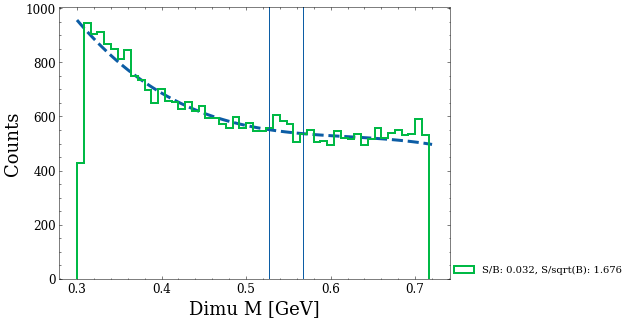

In [16]:
p0  = [5000, -20000, 30000, -10000]

plt.figure(figsize = (7,5))

bins = np.arange(SB_left, SB_right, width)
x = np.linspace(SB_left, SB_right, 100)



print(trial_test_set.shape)
popt_0, _, _, _, _ = curve_fit_m_inv(trial_test_set, "cubic", SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all)

plt.plot(x, bkg_fit_cubic(x, *popt_0), lw = 3, linestyle = "dashed")
num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(trial_test_set, bkg_fit_cubic, plot_bins_SR, SR_left, SR_right, popt_0)

print(num_S_expected_in_SR, num_B_expected_in_SR)

plt.hist(trial_test_set, bins = bins, lw = 2, histtype = "step", density = False, label = f"S/B: {round(num_S_expected_in_SR/num_B_expected_in_SR,3)}, S/sqrt(B): {round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR),3)}")

plt.xlabel("Dimu M [GeV]")
plt.ylabel("Counts")
plt.legend(loc = (1, 0))

plt.axvline(SR_left)
plt.axvline(SR_right)

plt.show()
 
    

In [17]:
with open(f"projects/{scaler_id}/processed_data/{project_id}_{particle_type}_nojet_train_band_data", "wb") as ofile:
    pickle.dump(train_data_dict, ofile)
        
        
with open(f"projects/{scaler_id}/processed_data/{project_id}_{particle_type}_nojet_test_band_data", "wb") as ofile:
    pickle.dump(test_data_dict, ofile)
    
    
with open(f"projects/{scaler_id}/processed_data/{project_id}_{particle_type}_nojet_samesign_band_data", "wb") as ofile:
    pickle.dump(proccessed_data_dict_samesign, ofile)
